## KNN prepoznavanje ručno napisanog teksta

Naš cilj je napraviti aplikaciju koja se može čitati znamenke u rukopisu. Za to su nam potrebni neki podaci za treniranje i podaci za testiranje. OpenCV dolazi s digits.png slikom (u mapi opencv/samples/data/), koji ima 5000 rukom pisanih znamenki (500 za svaku znamenku). Svaka znamenka je slika dimenzija 20x20. Dakle, naš prvi korak je podijeliti ovu sliku na 5000 različitih znamenki. Za svaku znamenku, sliku 20x20 ćemo pretvoriti u jednodimenzionalni vektor sa 400 piksela. To je naš skup značajki, odnosno vrijednosti intenziteta svih piksela. To je najjednostavniji skup značajki koji možemo stvoriti. U ovom primjeru koristi se prvih 250 uzoraka svake znamenke kao train_data, a uz 250 uzoraka kao test_data. Tako ćemo ih pripremiti, stoga počmimo.

Prvo ćemo učitati potrebne biblioteke, a nakon toga učitati digits.png sliku u memoriju.

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

Nakon što smo učitali potrebne datoteke, učitati ćemo sliku statičkom function cv2.imread koja prima 2 parametra, jedan parametar je relativna putanja do datoteke, a drugi parametar je hoće li sliku učitati kao crno-bijelu (engl. grayscale) ili u boji (početni parametar je učitavanje slike u boji).

In [2]:
img = cv2.imread('digits.png')
gray = cv2.imread('digits.png', 0)

Učitali smo u memoriju dvije slike jedna slika je u boji, a druga slika je crno-bijela (gray je crno-bijela, a img je slika u boji). Istražite kako je predstavljena slika u boji, a kako crno-bijela slika. Za prikaz koristiti ćemo naredbu od pyplot objekta imshow.

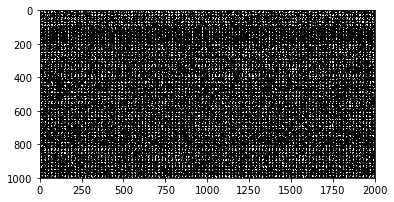

In [3]:
plt.imshow (img)

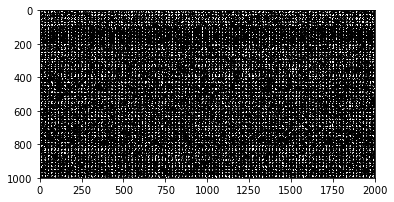

In [4]:
plt.imshow (gray, cmap="gray")

Budući da je slika crno-bijela obe slike su jednake. Probajte učitati sliku kod kuće koja je u boji te vidite koje ćete dobiti rezultate. Sada je potrebno ovu sliku pretvoriti u više manjih slika dimenzija 20x20 to možemo okomitom podjelom u 50 redaka i vodoravnom podjelom u 100 stupaca. Za okomitu podjelu koristiti ćemo metodu vsplit od naše slike koja je zapravo numpy niz (matrica).  

In [5]:
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]
x = np.array(cells)
x.shape

(50, 100, 20, 20)

Potrebno je cijelu sliku kako bila podobna za treniranje pretvoriti u jednodimanzionalni vektor kako bismo napravili skup za treniranje i za testiranje. Od niza slika napraviti ćemo niz jednodimenzionalnih vektora koji će predstavljati podatke za treniranje, kasnije ćemo dodati podatke za treniranje kako bismo ispitali preciznost našeg pristupa na većem skupu podataka od jedne slike.

In [6]:
train = x[:,0:100].reshape(-1,400).astype(np.float32)
test = x[:,50:100].reshape(-1, 400).astype(np.float32)
train.shape

(5000, 400)

Kada smo napravili slike za treniranje potrebno je napraviti model koji će na osnovu ovih podataka koji su mu služili za treniranje. Prevenstveno potrebno je slike označiti s odrovarajućim oznakama (brojevima od 0-9) stoga ćemo to i napraviti.

In [7]:
k = np.arange(10)
train_labels = np.repeat(k,500)[:,np.newaxis].astype(np.float32)
test_labels = np.repeat(k,250)[:,np.newaxis].astype(np.float32)
test_labels.shape

(2500, 1)

Sada kada smo označili, tj. napravili niz oznaka za svaku sliku potrebno je napraviti model, tj. istrenirati klasifikator da bi uspješno prepoznao oznaku određene slike.

In [8]:
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)

True

Sada je potrebno kada smo napravili model, testirati da li naš model ispravno prepoznaje slike. Uzeti ćemo jednu sliku iz niza x te vidjeti hoće li naš klasifikator ispravno prepoznati i klasificirati tu sliku.

Potrebno je izračunati kolika je preciznost ovog pristupa. 91% je ukupna preciznost sustava, a ova preciznost je izračunata kao odnos točno prepoznatih instanci netočno prepoznatih primjeraka.

In [9]:
ret,result,neighbours,dist = knn.findNearest(test,k=7)
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print( accuracy )

95.48


In [ ]:
%matplotlib notebook
from ipywidgets import *

<IPython.core.display.Javascript object>


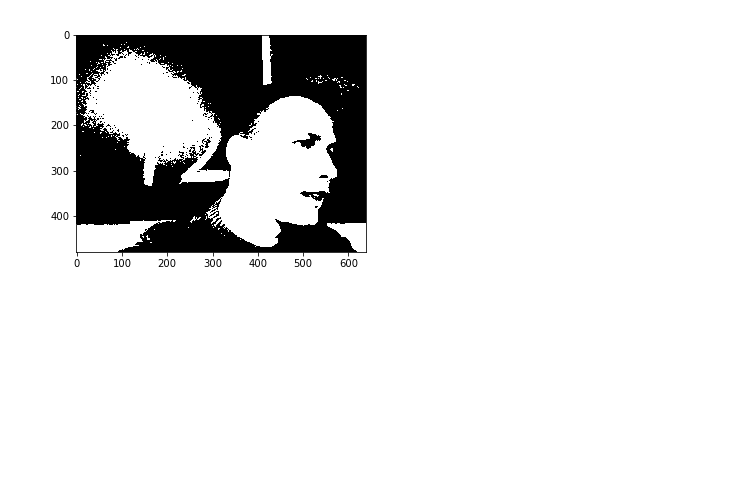

C:\Users\Daniel\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [ ]:
stream = cv2.VideoCapture (0)
stream.open(0)
plt.ion()

if stream.isOpened ():
    stvoren, slika = stream.read()
    slika = cv2.cvtColor(slika, cv2.COLOR_BGR2GRAY)
    kamera = plt.imshow(slika, cmap='gray')
else:
    stvoren = False
    
while stvoren:
    stvoren, slika = stream.read()
    slika = cv2.cvtColor(slika, cv2.COLOR_BGR2GRAY)
    
    _, maska = cv2.threshold(slika, 100, 255, cv2.THRESH_BINARY)
    _, konture, _ = cv2.findContours (maska, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    kamera.set_data (maska)
    
    for kontura in konture:
        try:
            x,y,w,h = cv2.boundingRect (kontura)
            if w/h > 0.4 and w/h < 1.4 and w > 20 and h > 20:
                broj = maska[y-20:y+h+20, x-20:x+w+20]
                if broj is not None:
                    broj = cv2.resize (broj, (20,20))
                    broj = broj.reshape(-1,400).astype(np.float32)
                    ret,result,neighbours,dist = knn.findNearest(broj,k=6)
                    cv2.putText (slika, str(int(ret)), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)
                    cv2.rectangle(slika,(x,y),(x+w,y+h),(255,255,255),2)
        except:
            pass
    #kamera.set_data (slika)
            
    plt.draw()
    
    try:
        plt.pause(0.01)
    except:
        pass